In [1]:
import os
import json 

import torch
import torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from accelerate import Accelerator
from diffusers import StableDiffusionPipeline
from diffusers import DDIMScheduler, DDPMPipeline
from diffusers.optimization import get_scheduler
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-09 09:00:38.470489: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-09 09:00:38.483998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:173

### Build Kanji Dataset Loader

In [1]:
def to_kanji_caption(definition):
    return f"Japanese calligraphy character meaning: '{definition}'. Character should be colored black on a white background."

In [3]:
class KanjiImageDataset(Dataset):
    def __init__(self, tokenizer, image_size=128):
        self.dataset_path = 'kanji_dataset'
        self.tokenizer = tokenizer
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

        self.gen_paths_and_captions()

    def gen_paths_and_captions(self):
        self.image_paths = []
        self.captions = []
        
        for root, dirs, files in os.walk(self.dataset_path):
            if len(files) == 0:
                continue
            
            img_path = None
            definition_path = None
            for file_name in files:
                if ".png" in file_name:
                    img_path = os.path.join(root, file_name)
                elif ".json":
                    definition_path = os.path.join(root, file_name)
            
            if img_path is None or definition_path is None:
                continue
            
            with open(definition_path, 'r') as f:
                definitions = json.load(f)
            
            for meaning in definitions:
                self.image_paths.append(img_path)
                self.captions.append(meaning)
                
        assert(len(self.image_paths) == len(self.captions))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = self.transform(image)
        
        caption = to_kanji_caption(self.captions[idx])
        encoded = self.tokenizer(
            caption,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt"
        )
        return {
            "pixel_values": image,
            "input_ids": encoded.input_ids[0],
            "attention_mask": encoded.attention_mask[0]
        }


In [4]:
torch.cuda.empty_cache()

if torch.cuda.is_available():
    torch.cuda.synchronize()
    current_device = torch.cuda.current_device()
    torch.cuda.empty_cache()

    print(f"Memory allocated: {torch.cuda.memory_allocated(current_device) / 1024**2:.2f} MB")
    print(f"Memory cached: {torch.cuda.memory_reserved(current_device) / 1024**2:.2f} MB")

Memory allocated: 0.00 MB
Memory cached: 0.00 MB


In [5]:
# Training Params
pretrained_model_name = "CompVis/stable-diffusion-v1-4"
output_dir = "finetuned_kanji_checkpoints"
train_batch_size = 64
num_train_epochs = 50
gradient_accumulation_steps = 4
learning_rate = 1e-6
lr_scheduler = "constant"
lr_warmup_steps = 0

# CLIP Inference Params
guidance_scale = 8
n_cuts = 4

accelerator = Accelerator(
    gradient_accumulation_steps=gradient_accumulation_steps,
    mixed_precision="fp16"
)

import wandb
wandb.init(
    project="stable-diffusion-finetuning",
    config={
        "model": pretrained_model_name,
        "learning_rate": learning_rate,
        "batch_size": train_batch_size,
        "epochs": num_train_epochs,
    }
)

wandb: Currently logged in as: akommula (akommula-bair). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [6]:
import open_clip

clip_model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="openai")
clip_model.to(accelerator.device)

# Transforms to resize and augment an image + normalize to match CLIP's training data
tfms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224),  
        torchvision.transforms.RandomAffine(5),  
        torchvision.transforms.RandomHorizontalFlip(),  
        torchvision.transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)

def clip_loss(image, text_features):
    image_features = clip_model.encode_image(tfms(image)) 
    input_normed = torch.nn.functional.normalize(image_features.unsqueeze(1), dim=2)
    embed_normed = torch.nn.functional.normalize(text_features.unsqueeze(0), dim=2)
    dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2) 
    return dists.mean()

/home/ubuntu/.local/lib/python3.10/site-packages/open_clip/factory.py:380: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


In [7]:
import matplotlib.pyplot as plt

sample_prompts = [
    "Armed Fish", 
    "Language Model", 
    "Climate Change", 
    "Baby Robot",
]

def plot_loss_curve(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

# TODO generation guided by CLIP loss!
def generate_samples(pipeline, prompts, device, epoch):
    images = []
    pipeline = pipeline.to(device)
    
    with torch.no_grad():
        for prompt in prompts:
            image = pipeline(
                to_kanji_caption(prompt), 
                num_inference_steps=50,
                guidance_scale=7.5
            ).images[0]
            images.append(image)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle('Generated Samples', fontsize=16)
    
    for idx, (ax, img, prompt) in enumerate(zip(axes.flat, images, prompts)):
        wandb.log({
            f"samples/image_{epoch}_{idx+1}": wandb.Image(
                img,
                caption=f"Epoch {epoch} - {prompt}"
            )
        })
            
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Prompt {idx + 1}:\n{prompt}", fontsize=10, wrap=True)
    
    plt.tight_layout()
    plt.show()

In [8]:
load_model = 'resume'

Loading Clip and Stable Diffusion...


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  9.02it/s]


Finished Loading
Device: cuda
Builing KanjiImageDataset...
Finished Building Dataset
Starting Training...

Generating samples for epoch 0...


100%|██████████| 50/50 [00:03<00:00, 13.26it/s]


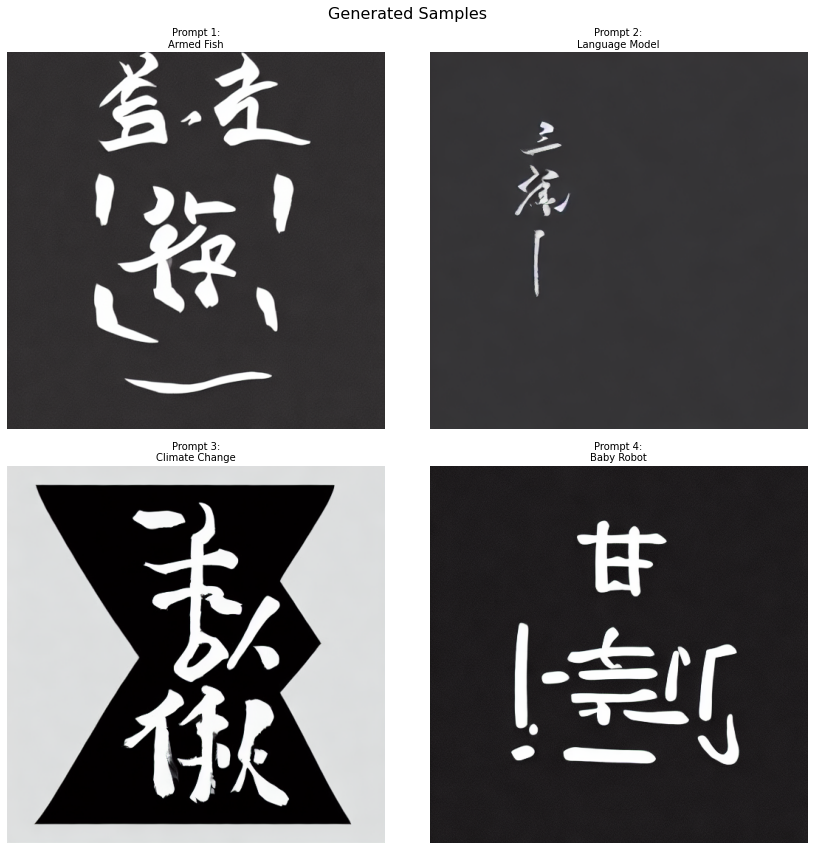

Epoch 0:   0%|          | 0/261 [00:00<?, ?it/s]/home/ubuntu/.local/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'PNDMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'PNDMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 0: 100%|██████████| 261/261 [03:56<00:00,  1.14it/s]

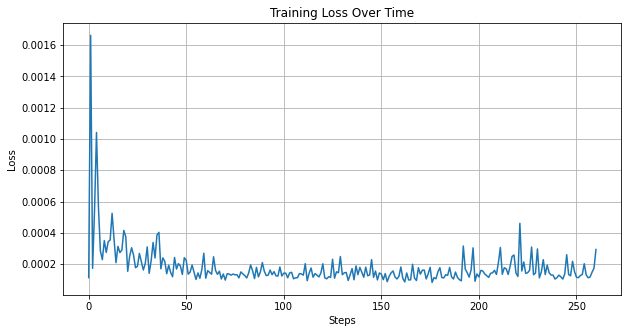

Epoch 0 - Average Loss: 0.0002

Generating samples for epoch 1...


100%|██████████| 50/50 [00:03<00:00, 12.84it/s]


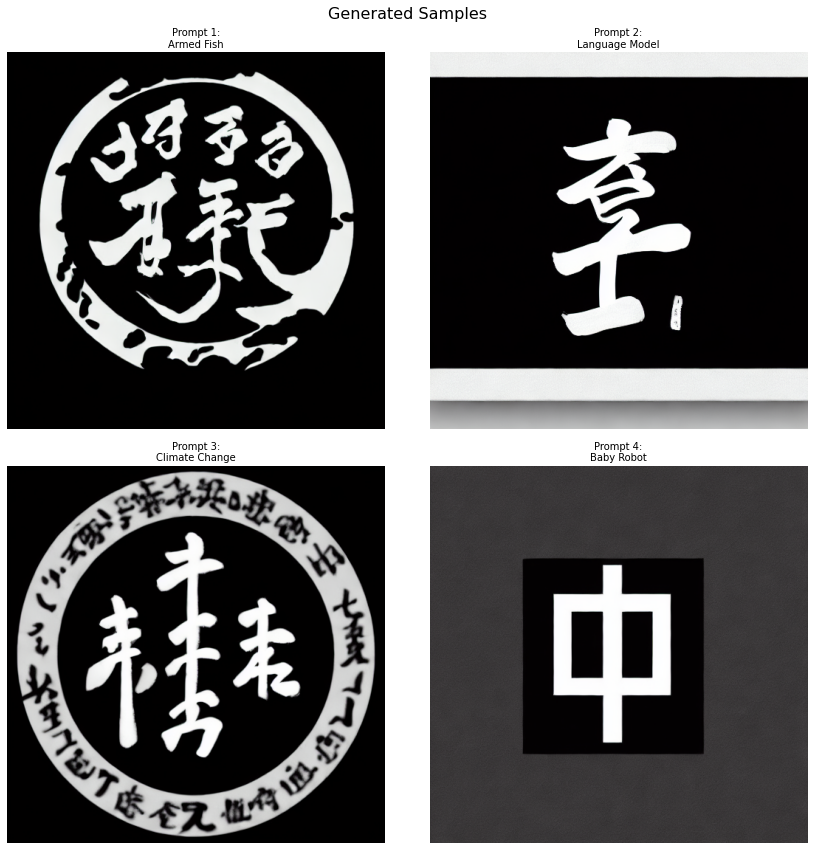

Epoch 0: 100%|██████████| 261/261 [04:22<00:00,  1.01s/it]


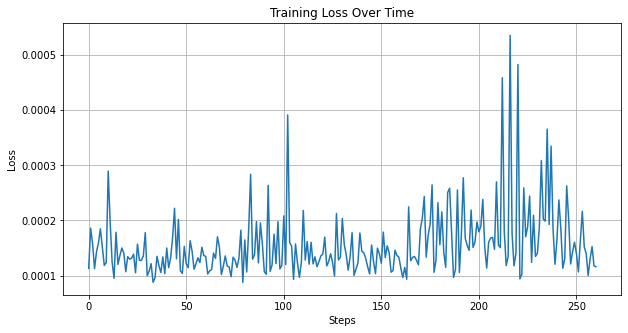

Epoch 1 - Average Loss: 0.0002

Generating samples for epoch 2...


100%|██████████| 50/50 [00:03<00:00, 12.93it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|██████████| 50/50 [00:03<00:00, 12.92it/s]


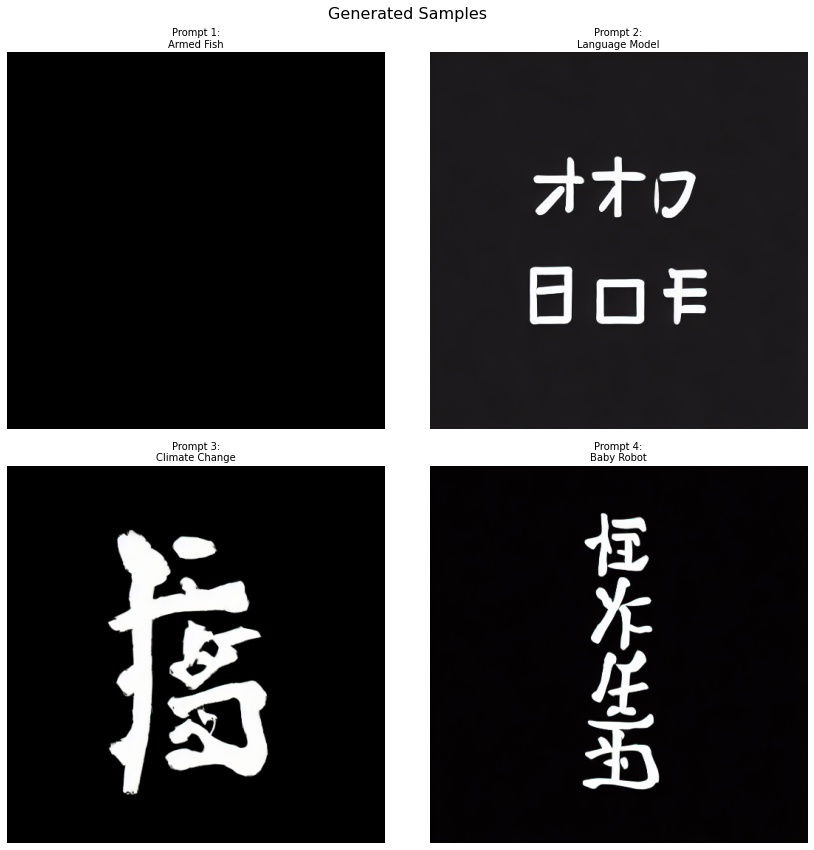

Epoch 2: 100%|██████████| 261/261 [03:58<00:00,  1.14it/s]

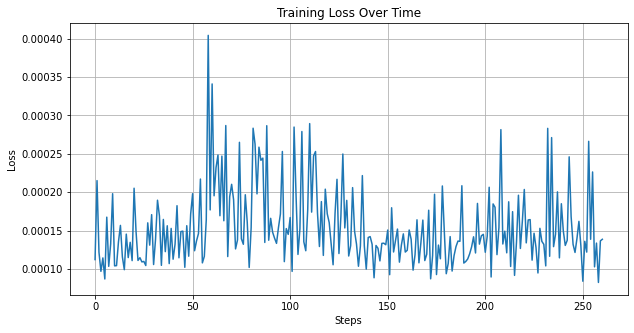

Epoch 2 - Average Loss: 0.0002

Generating samples for epoch 3...


100%|██████████| 50/50 [00:03<00:00, 12.85it/s]


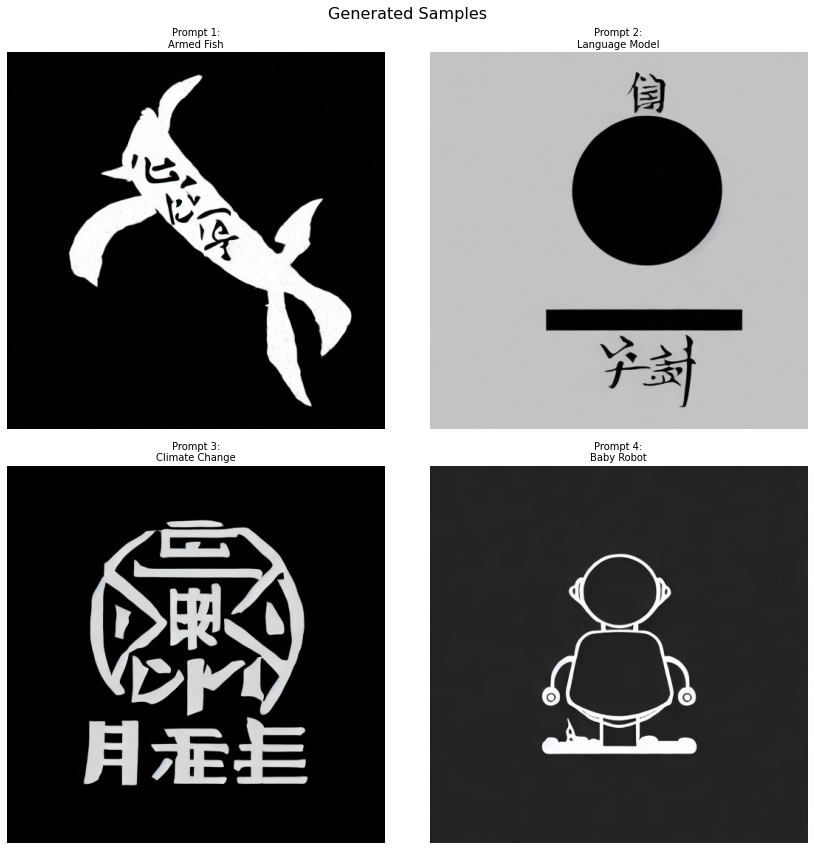

Epoch 2: 100%|██████████| 261/261 [04:23<00:00,  1.01s/it]


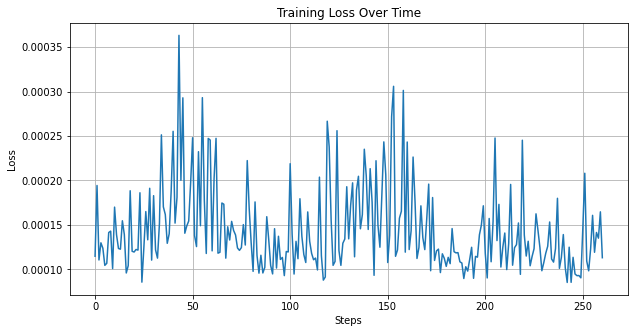

Epoch 3 - Average Loss: 0.0001

Generating samples for epoch 4...


100%|██████████| 50/50 [00:03<00:00, 12.92it/s]


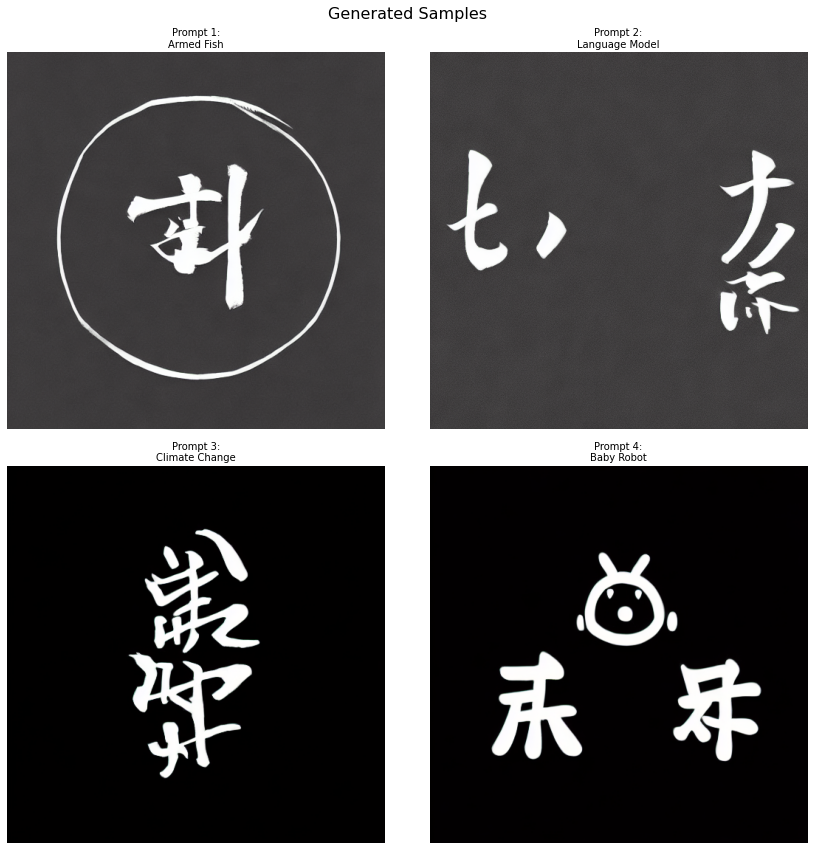

Epoch 4: 100%|██████████| 261/261 [03:58<00:00,  1.14it/s]

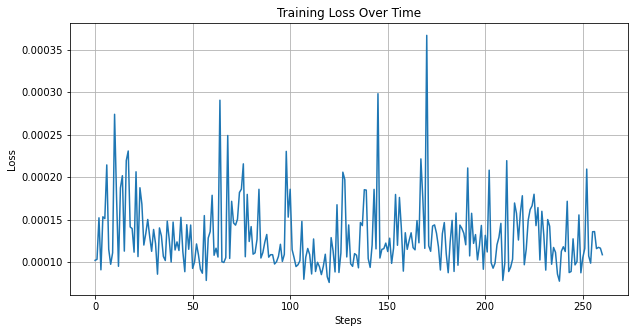

Epoch 4 - Average Loss: 0.0001

Generating samples for epoch 5...


100%|██████████| 50/50 [00:03<00:00, 12.86it/s]


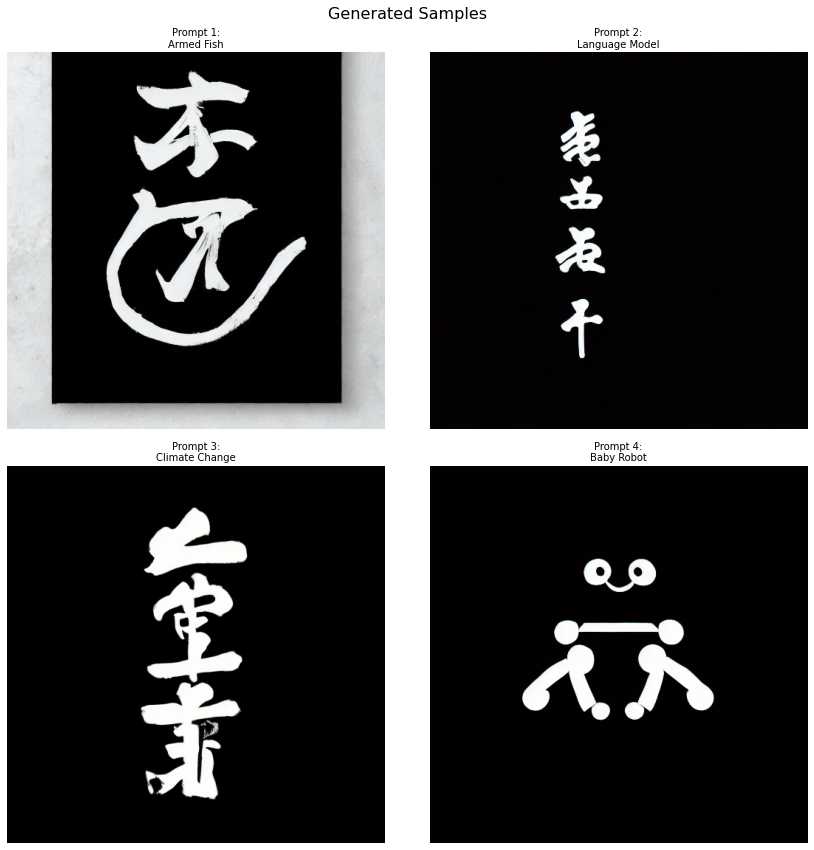

Epoch 4: 100%|██████████| 261/261 [04:25<00:00,  1.02s/it]


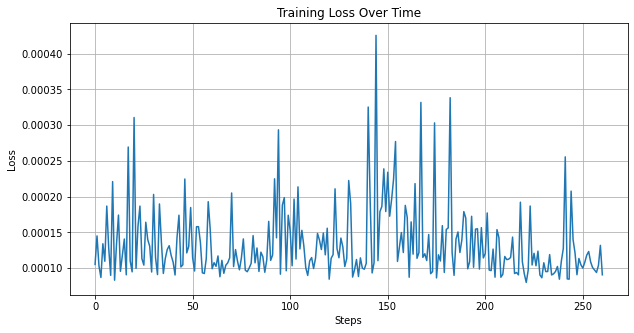

Epoch 5 - Average Loss: 0.0001

Generating samples for epoch 6...


100%|██████████| 50/50 [00:03<00:00, 12.91it/s]


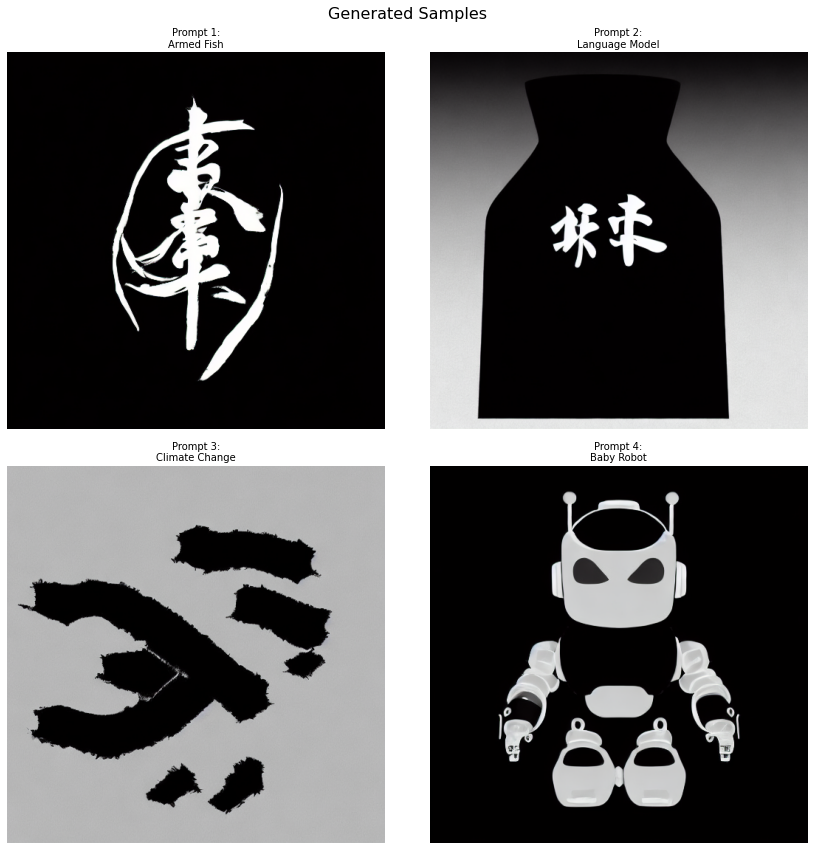

Epoch 6: 100%|██████████| 261/261 [03:58<00:00,  1.14it/s]

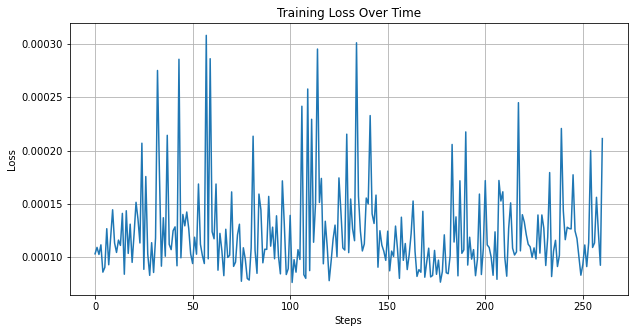

Epoch 6 - Average Loss: 0.0001

Generating samples for epoch 7...


100%|██████████| 50/50 [00:03<00:00, 12.86it/s]


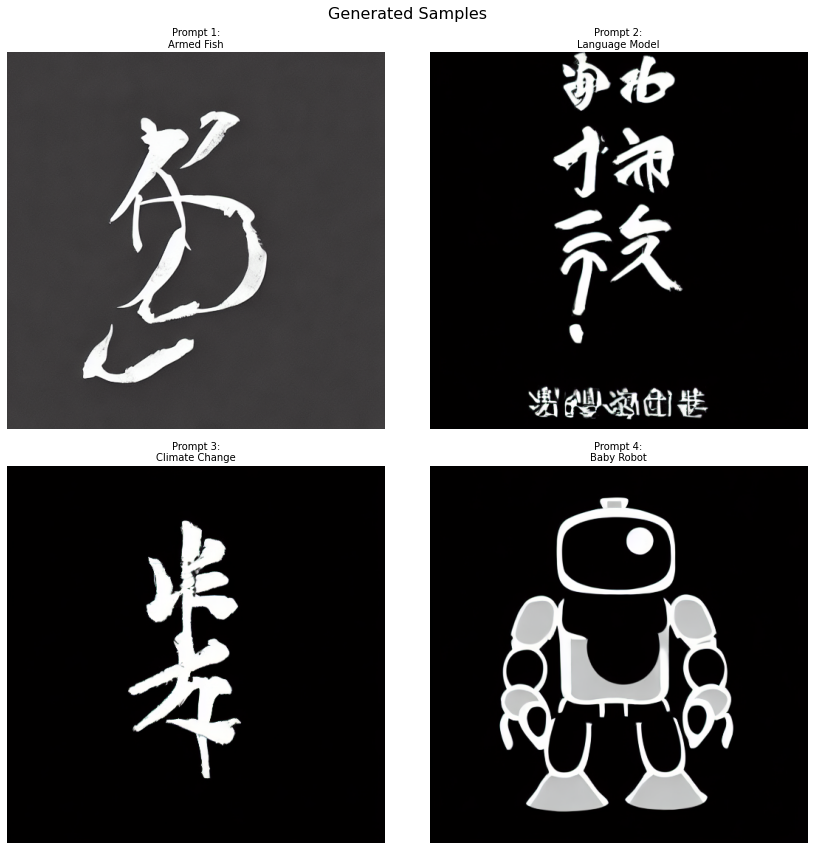

Epoch 6: 100%|██████████| 261/261 [04:24<00:00,  1.01s/it]


KeyboardInterrupt: 

In [9]:
print("Loading Clip and Stable Diffusion...")
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name,
    subfolder="tokenizer"
)
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name,
    subfolder="text_encoder"
)    


if load_model == 'resume':
    img_pipeline = StableDiffusionPipeline.from_pretrained(
        pretrained_model_name_or_path = output_dir,
    )
elif load_model == 'scratch':
    img_pipeline = StableDiffusionPipeline.from_pretrained(pretrained_model_name)


vae = img_pipeline.vae
unet = img_pipeline.unet

vae.requires_grad_(False)
text_encoder.requires_grad_(False)

vae = vae.to(accelerator.device)
text_encoder = text_encoder.to(accelerator.device)
unet = unet.to(accelerator.device)
print("Finished Loading")

print(f"Device: {accelerator.device}")

print("Builing KanjiImageDataset...")
kanji_dataset = KanjiImageDataset(tokenizer, image_size = 128)
train_dataloader = DataLoader(
    kanji_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
print("Finished Building Dataset")

optimizer = torch.optim.AdamW(
    unet.parameters(),
    lr=learning_rate
)

lr_scheduler = get_scheduler(
    name = "cosine",
    optimizer=optimizer,
    num_warmup_steps=lr_warmup_steps,
    num_training_steps=len(train_dataloader) * num_train_epochs
)

unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    unet, optimizer, train_dataloader, lr_scheduler
)

print("Starting Training...")
global_step = 0
losses = []

for epoch in range(num_train_epochs):
    print(f"\nGenerating samples for epoch {epoch}...")
    generate_samples(img_pipeline, sample_prompts, accelerator.device, epoch)
                
    unet.train()
    progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
    progress_bar.set_description(f"Epoch {epoch}")
    epoch_losses = []

    for batch in train_dataloader:  
        pixel_values = batch["pixel_values"].to(accelerator.device)
        
        latents = vae.encode(pixel_values).latent_dist.sample()
        latents = latents * 0.18215

        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, img_pipeline.scheduler.num_train_timesteps, (latents.shape[0],), device=latents.device)
        noisy_latents = img_pipeline.scheduler.add_noise(latents, noise, timesteps)

        with torch.no_grad():
            encoder_hidden_states = text_encoder(batch["input_ids"])[0]

        noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
        loss = F.mse_loss(noise_pred, noise, reduction="none").mean()
        epoch_losses.append(loss.item())
                
        accelerator.backward(loss)

        if accelerator.sync_gradients:
            accelerator.clip_grad_norm_(unet.parameters(), 1.0)
            
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        global_step += 1
        
        if global_step % 10 == 0:
            wandb.log({
                "train/loss": loss.item(),
                "train/learning_rate": optimizer.param_groups[0]["lr"],
                "train/epoch": epoch,
                "train/global_step": global_step,
            })
    
    if accelerator.is_main_process:
        # Save checkpoint
        pipeline = StableDiffusionPipeline(
            text_encoder=text_encoder,
            vae=vae,
            unet=accelerator.unwrap_model(unet),
            tokenizer=tokenizer,
            scheduler=img_pipeline.scheduler,
            safety_checker=img_pipeline.safety_checker,
            feature_extractor=img_pipeline.feature_extractor,
        )
        pipeline.save_pretrained(output_dir)
        
        plot_loss_curve(epoch_losses)
        
        # Print epoch stats
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        print(f"Epoch {epoch} - Average Loss: {avg_loss:.4f}")
        
        wandb.log({
            "epoch": epoch,
            "epoch/avg_loss": avg_loss
        })
        
        losses.append(avg_loss)
        
        # Clear CUDA cache
        torch.cuda.empty_cache()    
        
    
wandb.finish()
print("Training completed!")